# AI 전문가 교육과정 실습 2 - part 1

***
### NLP응용: 토픽 추출
Applied Natrual Language Processing: Topic Modeling

강사: 차미영 교수 (카이스트 전산학부)    
조교: 신민기, 정현규 (카이스트 전산학부)

# Data Preprocessing, LSA vs. LDA

In [8]:
import re
import string

In [9]:
import numpy as np
print(np.__file__)
print(np.ndarray)

c:\Users\AI_15\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\__init__.py
<class 'numpy.ndarray'>


In [10]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [11]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AI_15\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AI_15\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AI_15\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\AI_15\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data preprocessing and visualization

20newsgroups data: This dataset is a collection newsgroup documents. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

More detailed information: https://www.kaggle.com/crawford/20-newsgroups

In [7]:
dataset = fetch_20newsgroups(shuffle=True,
                            random_state=32,
                            remove=('headers', 'footers', 'qutes'))

In [12]:
for idx in range(3):
    print(dataset.data[idx],'\n\n','-'*100, '\n')

The real question here in my opinion is what Motorola processors running system
7 on a MAC are comparable to what Intel processors running Windows on a PC?  I
recall there being a conversation here that a 486/25 running Windows benchmarks
at about the same speed as 25Mhz 030 in system 7.  I don't know if that is
true, but I would love to hear if anyone has any technical data on this.

-David 

 ---------------------------------------------------------------------------------------------------- 

Please could someone in the US give me the current street 
prices on the following, with and without any relevant taxes:

 8 Mb 72 pin SIMM
16 Mb 72 pin SIMM (both for Mac LC III)

Are any tax refunds possible if they are to be exported
to the UK? Can you recommend a reliable supplier? 

 ---------------------------------------------------------------------------------------------------- 

Can somebody please help me with information about an
American Magnetics Corporation Magstripe Card Reader

In [13]:
news_df = pd.DataFrame({'News': dataset.data,
                       'Target': dataset.target})
news_df

,News,Target
0,The real question here in my opinion is what M...,4
1,Please could someone in the US give me the cur...,4
2,Can somebody please help me with information a...,12
3,In article <2077@rwing.UUCP> pat@rwing.UUCP (P...,16
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7
...,...,...
11309,In article <1qvs9t$q3f@usenet.INS.CWRU.Edu> Ch...,4
11310,"Hi,\nI've got a Multi I/O card (IDE controller...",3
11311,\n As a person who has rarely even SEEN Do...,10
11312,>> So they should sue the newspaper I got it f...,1


In [14]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [15]:
news_df['Target_name'] = news_df['Target'].apply(lambda x: dataset.target_names[x])
news_df.head(3)

,News,Target,Target_name
0,The real question here in my opinion is what M...,4,comp.sys.mac.hardware
1,Please could someone in the US give me the cur...,4,comp.sys.mac.hardware
2,Can somebody please help me with information a...,12,sci.electronics


### Simple analysis
Plot distribution of topics in news data

c:\Users\AI_15\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'comp.sys.mac.hardware'),
  Text(1, 0, 'sci.electronics'),
  Text(2, 0, 'talk.politics.guns'),
  Text(3, 0, 'rec.autos'),
  Text(4, 0, 'rec.sport.baseball'),
  Text(5, 0, 'misc.forsale'),
  Text(6, 0, 'soc.religion.christian'),
  Text(7, 0, 'alt.atheism'),
  Text(8, 0, 'sci.space'),
  Text(9, 0, 'rec.motorcycles'),
  Text(10, 0, 'comp.graphics'),
  Text(11, 0, 'comp.sys.ibm.pc.hardware'),
  Text(12, 0, 'rec.sport.hockey'),
  Text(13, 0, 'comp.os.ms-windows.misc'),
  Text(14, 0, 'talk.politics.misc'),
  Text(15, 0, 'sci.crypt'),
  Text(16, 0, 'comp.windows.x'),
  Text(17, 0, 'talk.religion.misc'),
  Text(18, 0, 'sci.med'),
  Text(19, 0, 'talk.politics.mideast')])

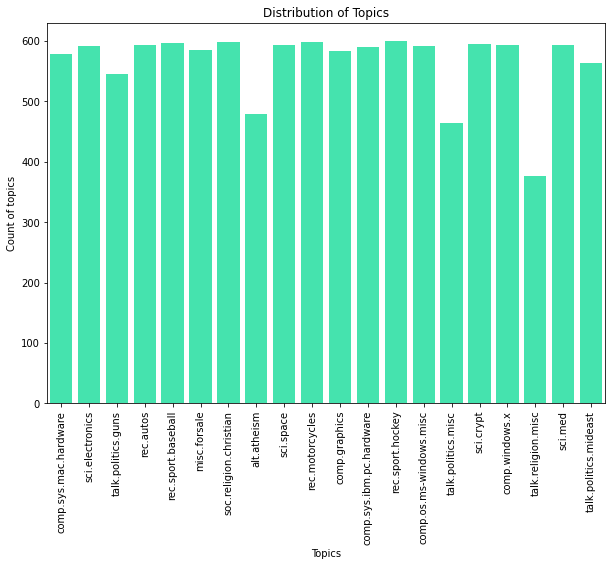

In [16]:
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(news_df['Target_name'], color=sns.xkcd_rgb['greenish cyan'])
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count of topics')
plt.xticks(rotation=90)

### Text preprocessing
1. Remove non-alphabetic sequences  
2. Remove stop words   
3. Lemmatize   
4. Remove very small words  

In [17]:
def clean_text(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower() # television, Television, TELEVISION
    sentence = pattern.sub(' ', sentence).strip()
    
    # Tokenize
    word_list = word_tokenize(sentence) 
    
    # stop words
    stopwords_list = set(stopwords.words('english'))
    
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    
    # lemmatize
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    
    # list to sentence
    sentence = ' '.join(word_list)
    
    return sentence

In [18]:
tqdm.pandas()
news_df['News'] = news_df['News'].progress_apply(lambda x: clean_text(str(x)))

100%|██████████| 11314/11314 [00:16<00:00, 705.74it/s]


Visualize the word clouds

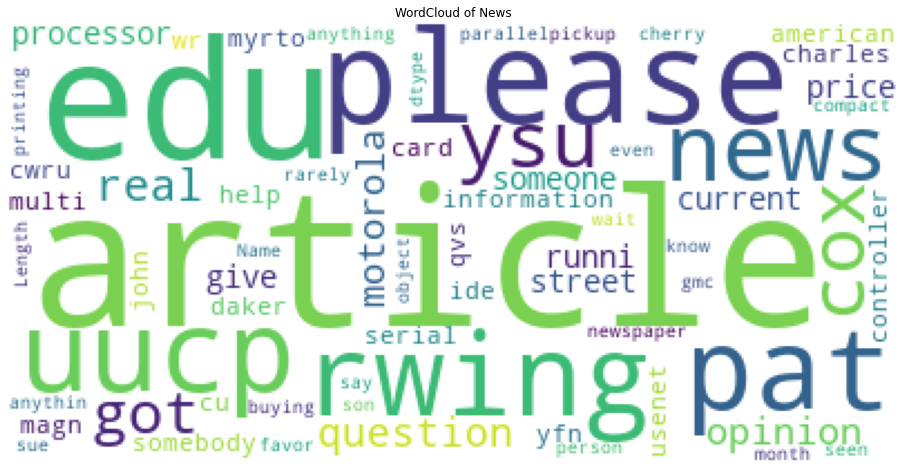

In [39]:
wordcloud = WordCloud(background_color='white',
                      max_words=200).generate(str(news_df['News']))
fig = plt.figure(figsize=[16,16])
plt.title('WordCloud of News')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Topic modeling - 1: LSA

### Construct news vectors
We use TF-IDF vectorizer

In [20]:
tfid_vec = TfidfVectorizer(tokenizer=lambda x: str(x).split(), max_df = 0.5, max_features=2000)
X = tfid_vec.fit_transform(news_df['News'])
X.shape

(11314, 2000)

### Train the model

In [21]:
svd_model = TruncatedSVD(n_components=20,
                         random_state=12,
                         n_iter=100,
                         algorithm='randomized')

svd_model.fit(X)

TruncatedSVD(n_components=20, n_iter=100, random_state=12)

In [22]:
# Matrix -> U x \sigma x V
svd_model.components_.shape # V (topic-term matrix)

(20, 2000)

In [23]:
doc_topic = svd_model.transform(X)
doc_topic.shape # U (document-topic matrix)

(11314, 20)

In [24]:
terms = tfid_vec.get_feature_names()
len(terms)

c:\Users\AI_15\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


2000

In [25]:
terms

['ability',
 'able',
 'absolute',
 'absolutely',
 'abuse',
 'ac',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accident',
 'according',
 'account',
 'accurate',
 'across',
 'act',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'adam',
 'adapter',
 'add',
 'added',
 'addition',
 'additional',
 'address',
 'administration',
 'admit',
 'advance',
 'advantage',
 'advice',
 'afraid',
 'age',
 'agency',
 'agent',
 'ago',
 'agree',
 'ahead',
 'aid',
 'air',
 'algorithm',
 'alive',
 'allow',
 'allowed',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'alt',
 'alternative',
 'although',
 'always',
 'amendment',
 'america',
 'american',
 'amiga',
 'among',
 'amount',
 'amp',
 'analysis',
 'andrew',
 'andy',
 'angeles',
 'animal',
 'announced',
 'anonymous',
 'another',
 'answer',
 'anti',
 'anybody',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'apartment',
 'app',
 'apparently',
 'appear',
 'appears',
 'apple',
 'application',
 'applied',
 'apply',
 'appr

In [26]:
def map_word2topic(components, terms):
    # create output series
    word2topics = pd.Series()
    
    for idx, component in enumerate(components):
        # map terms (words) with topic
        # which is probability of word given a topic P(w|t)
        term_topic = pd.Series(component, index=terms)
        # sort values based on probability
        term_topic.sort_values(ascending=False, inplace=True)
        # put result in series output
        word2topics['topic '+str(idx)] = list(term_topic.iloc[:10].index)
        
    return word2topics

In [27]:
word2topics = map_word2topic(svd_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics.index, word2topics):
    print(idx,'\t',item)

Topics		Words
topic 0 	 ['edu', 'would', 'one', 'com', 'article', 'like', 'know', 'get', 'people', 'think']
topic 1 	 ['window', 'file', 'card', 'thanks', 'drive', 'do', 'driver', 'program', 'system', 'anyone']
topic 2 	 ['game', 'edu', 'team', 'player', 'year', 'article', 'season', 'play', 'baseball', 'apr']
topic 3 	 ['edu', 'article', 'window', 'apr', 'com', 'file', 'uiuc', 'god', 'news', 'cso']
topic 4 	 ['window', 'game', 'god', 'team', 'file', 'player', 'win', 'jesus', 'christian', 'season']
topic 5 	 ['drive', 'god', 'edu', 'scsi', 'card', 'disk', 'controller', 'hard', 'ide', 'christian']
topic 6 	 ['com', 'window', 'car', 'driver', 'bike', 'drive', 'problem', 'netcom', 'do', 'gun']
topic 7 	 ['drive', 'key', 'scsi', 'edu', 'disk', 'window', 'system', 'chip', 'game', 'do']
topic 8 	 ['com', 'god', 'key', 'game', 'chip', 'netcom', 'jesus', 'team', 'card', 'christian']
topic 9 	 ['com', 'card', 'israel', 'israeli', 'arab', 'jew', 'armenian', 'please', 'thanks', 'people']
topic 10 

C:\Users\AI_15\AppData\Local\Temp\ipykernel_1732\1724720165.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  word2topics = pd.Series()


In [28]:
# get top3 topics for a news document
def get_top3_topics(x):
    top3 = list(x.sort_values(ascending=False).head(3).index) + list(x.sort_values(ascending=False).head(3).values)
    return top3

# map top3 topic words to news document
def map_topicword2doc(model, X, prefix):
    # output data frame column list
    cols = [prefix + '_topic_'+str(i+1)+'_name' for i in range(3)] + [prefix + '_topic_'+str(i+1)+'_prob' for i in range(3)]
    # doc to topic mapping
    doc_topic = model.fit_transform(X) # U matrix (Document-topic matrix)
    # list of topics
    topics = [prefix + '_topic'+str(i) for i in range(20)]
    # doc topic data frame
    doc_topic_df = pd.DataFrame(doc_topic, columns=topics)
    # map top 3 topics to doc
    outdf = doc_topic_df.progress_apply(lambda x: get_top3_topics(x), axis=1)
    # outdf is a series of list
    # convert it to a data frame
    outdf = pd.DataFrame(dict(zip(outdf.index, outdf.values))).T
    outdf.columns = cols
    
    return outdf

top_topics = map_topicword2doc(svd_model, X, 'lsa')
news_topics = pd.concat([news_df, top_topics], axis=1)

100%|██████████| 11314/11314 [00:02<00:00, 4918.62it/s]


In [29]:
news_topics = news_topics.infer_objects()

In [30]:
news_topics.dtypes

News                 object
Target                int32
Target_name          object
lsa_topic_1_name     object
lsa_topic_2_name     object
lsa_topic_3_name     object
lsa_topic_1_prob    float64
lsa_topic_2_prob    float64
lsa_topic_3_prob    float64
dtype: object

In [31]:
news_topics.head(5)

,News,Target,Target_name,lsa_topic_1_name,lsa_topic_2_name,lsa_topic_3_name,lsa_topic_1_prob,lsa_topic_2_prob,lsa_topic_3_prob
0,real question opinion motorola processor runni...,4,comp.sys.mac.hardware,lsa_topic1,lsa_topic0,lsa_topic19,0.198148,0.153402,0.095548
1,please could someone give current street price...,4,comp.sys.mac.hardware,lsa_topic0,lsa_topic5,lsa_topic1,0.091736,0.051772,0.049500
2,somebody please help information american magn...,12,sci.electronics,lsa_topic10,lsa_topic0,lsa_topic1,0.105922,0.104279,0.098224
3,article rwing uucp pat rwing uucp pat myrto wr...,16,talk.politics.guns,lsa_topic0,lsa_topic16,lsa_topic11,0.085201,0.036481,0.023952
4,article news ysu edu yfn ysu edu john daker cu...,7,rec.autos,lsa_topic0,lsa_topic6,lsa_topic3,0.287837,0.093877,0.068941


# Topic modeling - 2: LDA

### Construct news vectors
We use Count vectorizer

In [32]:
count_vec = CountVectorizer(tokenizer=lambda x: str(x).split(), min_df=3, max_features=2000)
X = count_vec.fit_transform(news_df['News'])
X.shape

(11314, 2000)

### Train the model

In [33]:
# lda instance
lda_model = LatentDirichletAllocation(n_components=20,
                                     random_state=12,
                                     learning_method='online',
                                     max_iter=5,
                                     learning_offset=50)
# fit model
lda_model.fit(X)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          max_iter=5, n_components=20, random_state=12)

In [34]:
lda_model.components_.shape

(20, 2000)

In [35]:
doc_topic_lda = lda_model.transform(X)
doc_topic_lda.shape

(11314, 20)

In [36]:
word2topics_lda = map_word2topic(lda_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics_lda.index, word2topics_lda):
    print(idx,'\t',item)

Topics		Words
topic 0 	 ['president', 'clipper', 'task', 'bill', 'joe', 'value', 'connect', 'however', 'step', 'gone']
topic 1 	 ['power', 'winning', 'usa', 'group', 'link', 'citizen', 'one', 'radio', 'use', 'sign']
topic 2 	 ['people', 'armenian', 'one', 'said', 'chip', 'witness', 'jewish', 'worth', 'say', 'turkish']
topic 3 	 ['thank', 'knowing', 'anyone', 'please', 'worth', 'mailing', 'getting', 'one', 'hence', 'needed']
topic 4 	 ['col', 'guarantee', 'country', 'cold', 'christ', 'intel', 'great', 'usually', 'frame', 'crypto']
topic 5 	 ['year', 'news', 'student', 'universe', 'research', 'natural', 'central', 'april', 'initial', 'science']
topic 6 	 ['guy', 'right', 'lcs', 'grant', 'starting', 'people', 'weak', 'criminal', 'worth', 'first']
topic 7 	 ['seriously', 'listed', 'wide', 'come', 'mode', 'education', 'far', 'application', 'motion', 'request']
topic 8 	 ['maximum', 'bhj', 'gmt', 'willing', 'cipher', 'san', 'child', 'develop', 'bxn', 'boston']
topic 9 	 ['year', 'teaching', 

C:\Users\AI_15\AppData\Local\Temp\ipykernel_1732\1724720165.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  word2topics = pd.Series()


In [37]:
top_topics = map_topicword2doc(lda_model, X, 'lda')
news_topics = pd.concat([news_df, top_topics], axis=1)

100%|██████████| 11314/11314 [00:02<00:00, 4896.36it/s]


In [38]:
news_topics = news_topics.infer_objects()
news_topics.head(5)

,News,Target,Target_name,lda_topic_1_name,lda_topic_2_name,lda_topic_3_name,lda_topic_1_prob,lda_topic_2_prob,lda_topic_3_prob
0,real question opinion motorola processor runni...,4,comp.sys.mac.hardware,lda_topic19,lda_topic3,lda_topic17,0.514639,0.357066,0.097937
1,please could someone give current street price...,4,comp.sys.mac.hardware,lda_topic3,lda_topic0,lda_topic18,0.790020,0.101988,0.065492
2,somebody please help information american magn...,12,sci.electronics,lda_topic3,lda_topic1,lda_topic5,0.518715,0.234854,0.171902
3,article rwing uucp pat rwing uucp pat myrto wr...,16,talk.politics.guns,lda_topic10,lda_topic0,lda_topic17,0.663031,0.195825,0.107144
4,article news ysu edu yfn ysu edu john daker cu...,7,rec.autos,lda_topic13,lda_topic18,lda_topic10,0.533226,0.170965,0.158564
